# Authors - Justin Clifton, Julia Januchowski

---
## Table of Contents (Work In Progress)

1. [Introduction](#intro)
2. [Basic Exploration & Cleaning](#cleaning) 
3. [Data Visualization](#visualization)
4. [Modeling](#modeling)
---


## Introduction <a class="anchor" id="intro"></a>



In this notebook, we will be extending the work that was done in this [project](https://github.com/juliajanu/Math475_Project_4-/blob/master/nba_stats.ipynb) by using the dataset that was created. We will analyze the data and attempt to create a useful model for predicting the NBA MVP.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import joblib

#models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier as ABC

#feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

#scalers
from sklearn.preprocessing import StandardScaler

#score function
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Basic Exploration & Cleaning <a class="anchor" id="cleaning"></a>

In [2]:
stats_df = pd.read_csv('../data/NBA_Stats_MVP.csv')

In [3]:
stats_df.head()

,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,TRB,AST,STL,BLK,TOV,PF,PTS,is_allstar,Name,was_mvp
0,1974.0,C,27.0,HOU,79.0,NaN,2459.0,15.9,0.516,NaN,...,923.0,166.0,80.0,104.0,NaN,227.0,865.0,0,Zaid Abdul-Aziz,0
1,1974.0,C,26.0,MIL,81.0,NaN,3548.0,24.4,0.564,NaN,...,1178.0,386.0,112.0,283.0,NaN,238.0,2191.0,1,Kareem Abdul-Jabbar,1
2,1974.0,SF,26.0,DET,74.0,NaN,2298.0,10.9,0.457,NaN,...,448.0,141.0,110.0,12.0,NaN,242.0,759.0,0,Don Adams,0
3,1974.0,PG,27.0,CHI,55.0,NaN,618.0,10.0,0.447,NaN,...,69.0,56.0,36.0,1.0,NaN,63.0,182.0,0,Rick Adelman,0
4,1974.0,PG,26.0,MIL,72.0,NaN,2388.0,18.8,0.536,NaN,...,291.0,374.0,137.0,22.0,NaN,215.0,1268.0,0,Lucius Allen,0


In [4]:
stats_df.describe()

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,is_allstar,was_mvp
count,20797.000000,20797.000000,20797.000000,18233.000000,20797.000000,20792.000000,20715.000000,18839.000000,20703.000000,20792.000000,...,20797.000000,20797.000000,20797.000000,20797.000000,20797.000000,19645.000000,20797.000000,20797.000000,20797.000000,20797.000000
mean,1998.155840,26.773477,50.263836,23.593375,1180.121796,12.453867,0.502274,0.158604,0.318799,6.181565,...,147.199404,209.388614,112.975237,39.897052,24.470260,73.939832,111.226860,496.276242,0.039813,0.002116
std,12.232484,3.945470,26.681105,28.632387,929.215744,6.100548,0.093337,0.187495,0.226552,4.872685,...,145.921912,207.772110,137.240043,38.713053,36.935084,67.713803,82.445297,484.090240,0.195525,0.045949
min,1974.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1988.000000,24.000000,27.000000,0.000000,325.000000,9.800000,0.471000,0.005000,0.199000,2.600000,...,33.000000,48.000000,18.000000,9.000000,3.000000,18.000000,37.000000,100.000000,0.000000,0.000000
50%,1999.000000,26.000000,56.000000,8.000000,1013.000000,12.700000,0.514000,0.064000,0.286000,5.400000,...,106.000000,149.000000,64.000000,29.000000,11.000000,55.000000,102.000000,348.000000,0.000000,0.000000
75%,2009.000000,29.000000,76.000000,45.000000,1926.000000,15.600000,0.549000,0.288000,0.392000,9.000000,...,212.000000,302.000000,157.000000,60.000000,29.000000,112.000000,174.000000,764.000000,0.000000,0.000000
max,2017.000000,44.000000,87.000000,83.000000,3638.000000,129.100000,1.136000,1.000000,6.000000,100.000000,...,1111.000000,1530.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,3041.000000,1.000000,1.000000


In [5]:
stats_df.isnull().sum() > 0

Year          False
Pos           False
Age           False
Tm            False
G             False
GS             True
MP            False
PER            True
TS%            True
3PAr           True
FTr            True
ORB%           True
DRB%           True
TRB%           True
AST%           True
STL%           True
BLK%           True
TOV%           True
USG%           True
OWS           False
DWS           False
WS            False
WS/48          True
OBPM          False
DBPM          False
BPM           False
VORP          False
FG            False
FGA           False
FG%            True
3P             True
3PA            True
3P%            True
2P            False
2PA           False
2P%            True
eFG%           True
FT            False
FTA           False
FT%            True
ORB           False
DRB           False
TRB           False
AST           False
STL           False
BLK           False
TOV            True
PF            False
PTS           False
is_allstar    False


In [6]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20797 entries, 0 to 20796
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        20797 non-null  float64
 1   Pos         20797 non-null  object 
 2   Age         20797 non-null  float64
 3   Tm          20797 non-null  object 
 4   G           20797 non-null  float64
 5   GS          18233 non-null  float64
 6   MP          20797 non-null  float64
 7   PER         20792 non-null  float64
 8   TS%         20715 non-null  float64
 9   3PAr        18839 non-null  float64
 10  FTr         20703 non-null  float64
 11  ORB%        20792 non-null  float64
 12  DRB%        20792 non-null  float64
 13  TRB%        20792 non-null  float64
 14  AST%        20792 non-null  float64
 15  STL%        20792 non-null  float64
 16  BLK%        20792 non-null  float64
 17  TOV%        19582 non-null  float64
 18  USG%        19640 non-null  float64
 19  OWS         20797 non-nul

In [7]:
stats_df.fillna(0, inplace = True)

In [8]:
stats_df.isnull().sum() > 0

Year          False
Pos           False
Age           False
Tm            False
G             False
GS            False
MP            False
PER           False
TS%           False
3PAr          False
FTr           False
ORB%          False
DRB%          False
TRB%          False
AST%          False
STL%          False
BLK%          False
TOV%          False
USG%          False
OWS           False
DWS           False
WS            False
WS/48         False
OBPM          False
DBPM          False
BPM           False
VORP          False
FG            False
FGA           False
FG%           False
3P            False
3PA           False
3P%           False
2P            False
2PA           False
2P%           False
eFG%          False
FT            False
FTA           False
FT%           False
ORB           False
DRB           False
TRB           False
AST           False
STL           False
BLK           False
TOV           False
PF            False
PTS           False
is_allstar    False


In [9]:
pos_dummies = pd.get_dummies(stats_df.Pos,drop_first =True, prefix = "Position")
stats_df = pd.concat([stats_df, pos_dummies], axis = 1)


In [10]:
stats_df

,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,Position_PG,Position_PG-SF,Position_PG-SG,Position_SF,Position_SF-PF,Position_SF-SG,Position_SG,Position_SG-PF,Position_SG-PG,Position_SG-SF
0,1974.0,C,27.0,HOU,79.0,0.0,2459.0,15.9,0.516,0.000,...,0,0,0,0,0,0,0,0,0,0
1,1974.0,C,26.0,MIL,81.0,0.0,3548.0,24.4,0.564,0.000,...,0,0,0,0,0,0,0,0,0,0
2,1974.0,SF,26.0,DET,74.0,0.0,2298.0,10.9,0.457,0.000,...,0,0,0,1,0,0,0,0,0,0
3,1974.0,PG,27.0,CHI,55.0,0.0,618.0,10.0,0.447,0.000,...,1,0,0,0,0,0,0,0,0,0
4,1974.0,PG,26.0,MIL,72.0,0.0,2388.0,18.8,0.536,0.000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,...,0,0,0,0,0,0,0,0,0,0
20793,2017.0,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,...,0,0,0,0,0,0,0,0,0,0
20794,2017.0,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,...,0,0,0,0,0,0,0,0,0,0
20795,2017.0,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,...,0,0,0,1,0,0,0,0,0,0


## Feature Engineering <a class="anchor" id="engineering"></a>

The "50–40–90 club" is an informal statistic that requires a player to achieve 50% field goal percentage, 40% three-point field goal percentage and 90% free throw percentage over the course of a regular season. In NBA history, only eight players have recorded a 50–40–90 season. We will add this as a feature in our dataset. The NBA requires a player to make at least 300 field goals, 82 three-pointers, and 125 free throws to be eligible.

In [11]:
club_50_40_90 = stats_df[(stats_df['FT%'] >= 0.9) & (stats_df['3P%'] >= .40) & (stats_df['FG%'] >= .5)
                         & (stats_df['FGA'] >= 300) & (stats_df['3PA'] >= 82) & (stats_df['FTA'] >= 125)]
club_50_40_90['Name']

4461        Larry Bird
4840        Larry Bird
5541        Mark Price
7787     Reggie Miller
14137       Steve Nash
14685    Dirk Nowitzki
15243       Steve Nash
15836       Steve Nash
16436       Steve Nash
17937     Kevin Durant
19740    Stephen Curry
Name: Name, dtype: object

In [12]:
#makes a column where an entry gets a 0 if it does not match condition, 1 if it does.
stats_df['50-40-90'] = np.where((stats_df['FT%'] >= 0.9) & (stats_df['3P%'] >= .40) & (stats_df['FG%'] >= .5) 
                         & (stats_df['FGA'] >= 300) & (stats_df['3PA'] >= 82) & (stats_df['FTA'] >= 125),1, 0)

In [13]:
stats_df['injured'] = np.where((stats_df['G'] < 49),1, 0)

This dataset lacks per game averages. We will add these as columns.

In [14]:
def per_game(stats_df, cols):
    """
    returns a new data frame version of stats_df, where a per game average is added for each column name 
    contained within cols
    
    :param stats_df: A dataframe containing basketball stats.
    :param cols: A list of column names where per game averages are desired.
    :return: A new dataframe containing per game averages for stats contained within cols. 
    :rtype: Dataframe
    """
    new_df = stats_df.copy()
    for col in cols:
        new_df[col + 'PG'] = stats_df[col]/stats_df['G']
    return new_df

In [15]:
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
stats_df = per_game(stats_df, per_game_cols)

In [16]:
stats_df['directly_invoved_off_PG'] = stats_df['PTSPG'] + stats_df["ASTPG"]

In [17]:
stats_df['directly_invoved_def_PG'] = stats_df['STLPG'] + stats_df["BLKPG"]

## Data Visualization <a class="anchor" id="visualization"></a>

No injured player has ever won the MVP. This should be a helpful feature for our models.

/tmp/ipykernel_28186/2366012053.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = stats_df


<AxesSubplot: xlabel='injured', ylabel='was_mvp'>

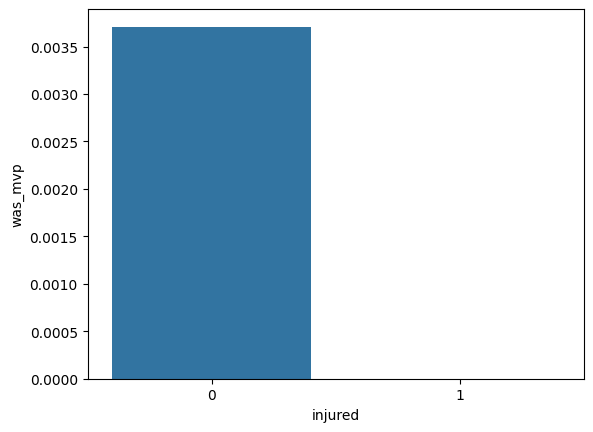

In [18]:
sns.barplot(data = stats_df
            ,x = 'injured'
            ,y = 'was_mvp',
            ci = None
            )

We will now look at all of our MVP players. 

In [19]:
stats_df[stats_df["was_mvp"] == 1]['Name']

1        Kareem Abdul-Jabbar
403               Bob McAdoo
522      Kareem Abdul-Jabbar
796      Kareem Abdul-Jabbar
1490             Bill Walton
1724            Moses Malone
1870     Kareem Abdul-Jabbar
2321           Julius Erving
2813            Moses Malone
3185            Moses Malone
3369              Larry Bird
3712              Larry Bird
4077              Larry Bird
4595           Magic Johnson
5004          Michael Jordan
5417           Magic Johnson
5868           Magic Johnson
6344          Michael Jordan
6797          Michael Jordan
7067         Charles Barkley
7817         Hakeem Olajuwon
8310          David Robinson
8655          Michael Jordan
9269             Karl Malone
9779          Michael Jordan
10360            Karl Malone
10929       Shaquille O'Neal
11308          Allen Iverson
11764             Tim Duncan
12249             Tim Duncan
12793          Kevin Garnett
13570             Steve Nash
14137             Steve Nash
14685          Dirk Nowitzki
14940         

In [20]:
mvps_df = stats_df[stats_df["was_mvp"] == 1]

<AxesSubplot: ylabel='PTSPG'>

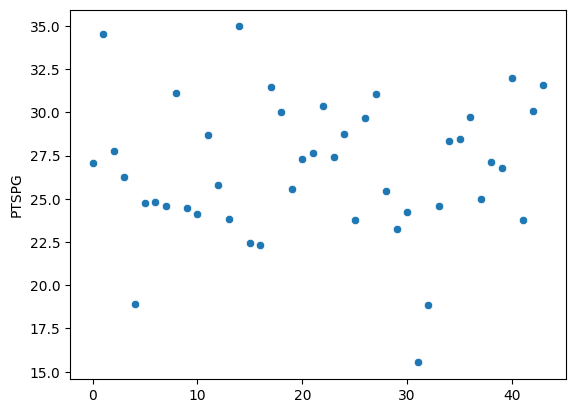

In [21]:
sns.scatterplot(data = mvps_df, x = range(len(mvps_df.index)), y = "PTSPG")

In [22]:
mvps_df['PTSPG'].min()

15.533333333333333

In [23]:
stats_df['>15pts'] = np.where((stats_df['PTSPG'] >= 20),1, 0)

<AxesSubplot: ylabel='Age'>

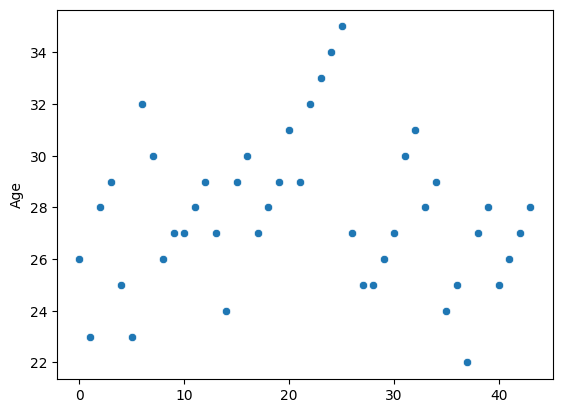

In [24]:
sns.scatterplot(data = mvps_df, x = range(len(mvps_df.index)), y = "Age")

In [25]:
mvps_df['Age'].min()

22.0

In [26]:
stats_df['>22age'] = np.where((stats_df['PTSPG'] >= 22),1, 0)

## Modeling <a class="anchor" id="modeling"></a>

In [27]:
stats_df = stats_df.drop(columns = ['Pos', 'Name', 'Tm'])
X = stats_df.drop(columns = ['was_mvp'])
y = stats_df['was_mvp']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 23)

This will serve as our base model.

In [29]:
random_classif = RFC(n_estimators=100)
random_classif.fit(X_train, y_train)

RandomForestClassifier()

<AxesSubplot: ylabel='cols'>

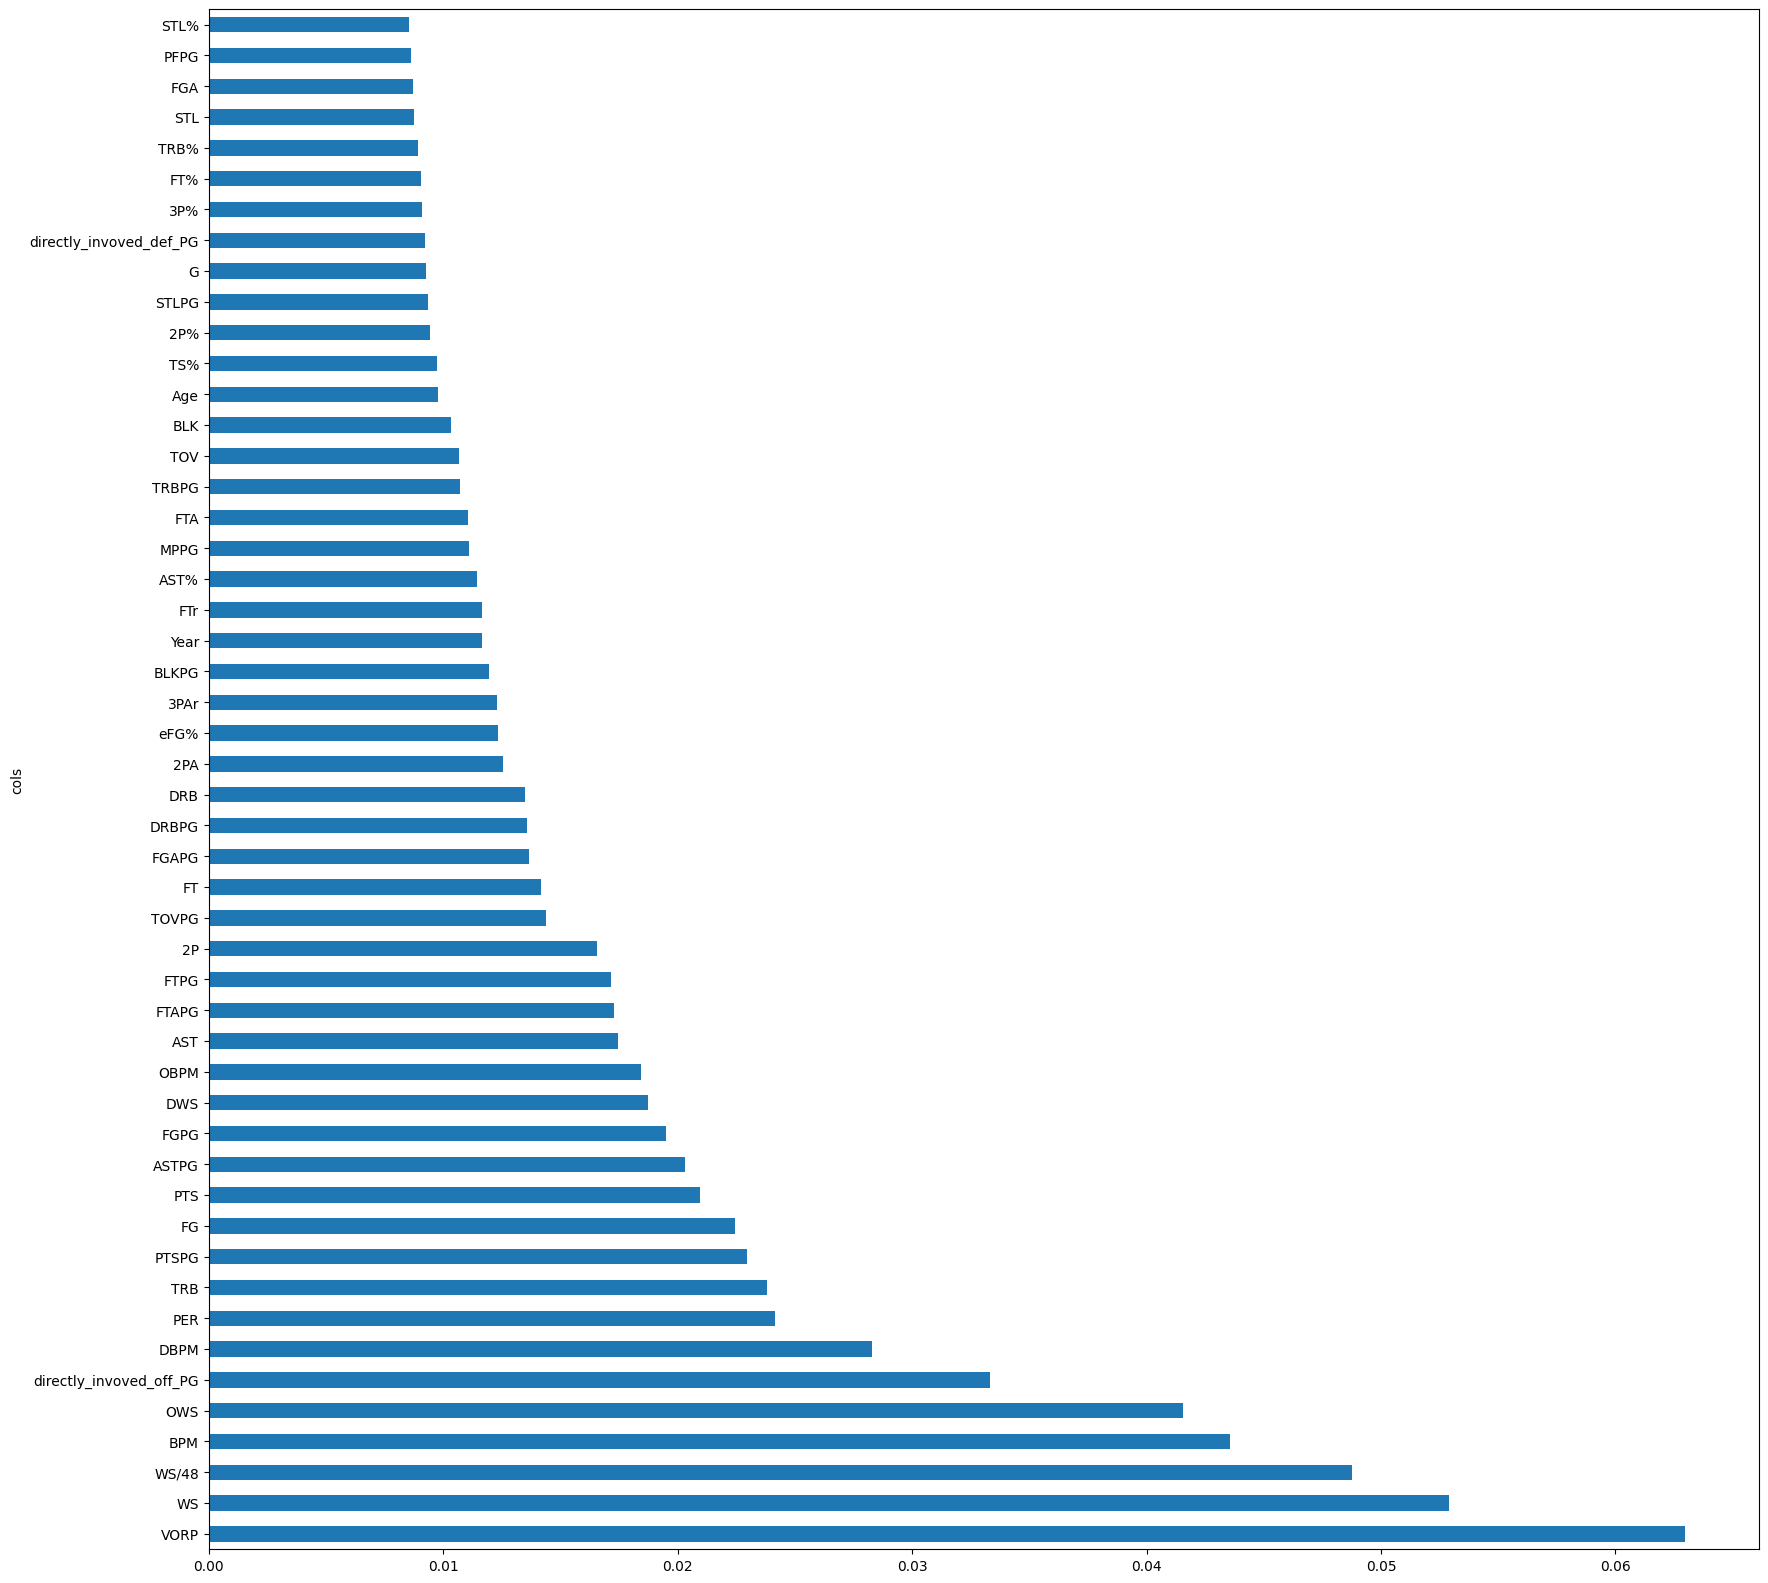

In [30]:
def rf_feat_importance(m, df):
    """
    This function will show us the feature importance according to a random forest model.
    
    :param m: The random forest model.
    :param df: The dataframe.
    :return: A dataframe of feature importances.
    """
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    """
    Function used for plotting feature importances from a random forest.
    :param fi: A dataframe containing features and their importance.
    :return: A plot of the feature importances. 
    """
    return fi.plot('cols', 'imp', 'barh', figsize=(20,20), legend=False)

plot_fi(rf_feat_importance(random_classif, X_train)[:50])

In [31]:
f1_score(y_test, random_classif.predict(X_test), average='macro')

0.5468565466157569

This model achieves a test f1 score of 54%. 

In [32]:
scaler = StandardScaler()
random_classif2 = RFC(n_estimators=100)
pipe = make_pipeline(scaler, random_classif2)
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [33]:
f1_score(y_test, pipe.predict(X_test), average='macro')

0.5468565466157569

<AxesSubplot: ylabel='cols'>

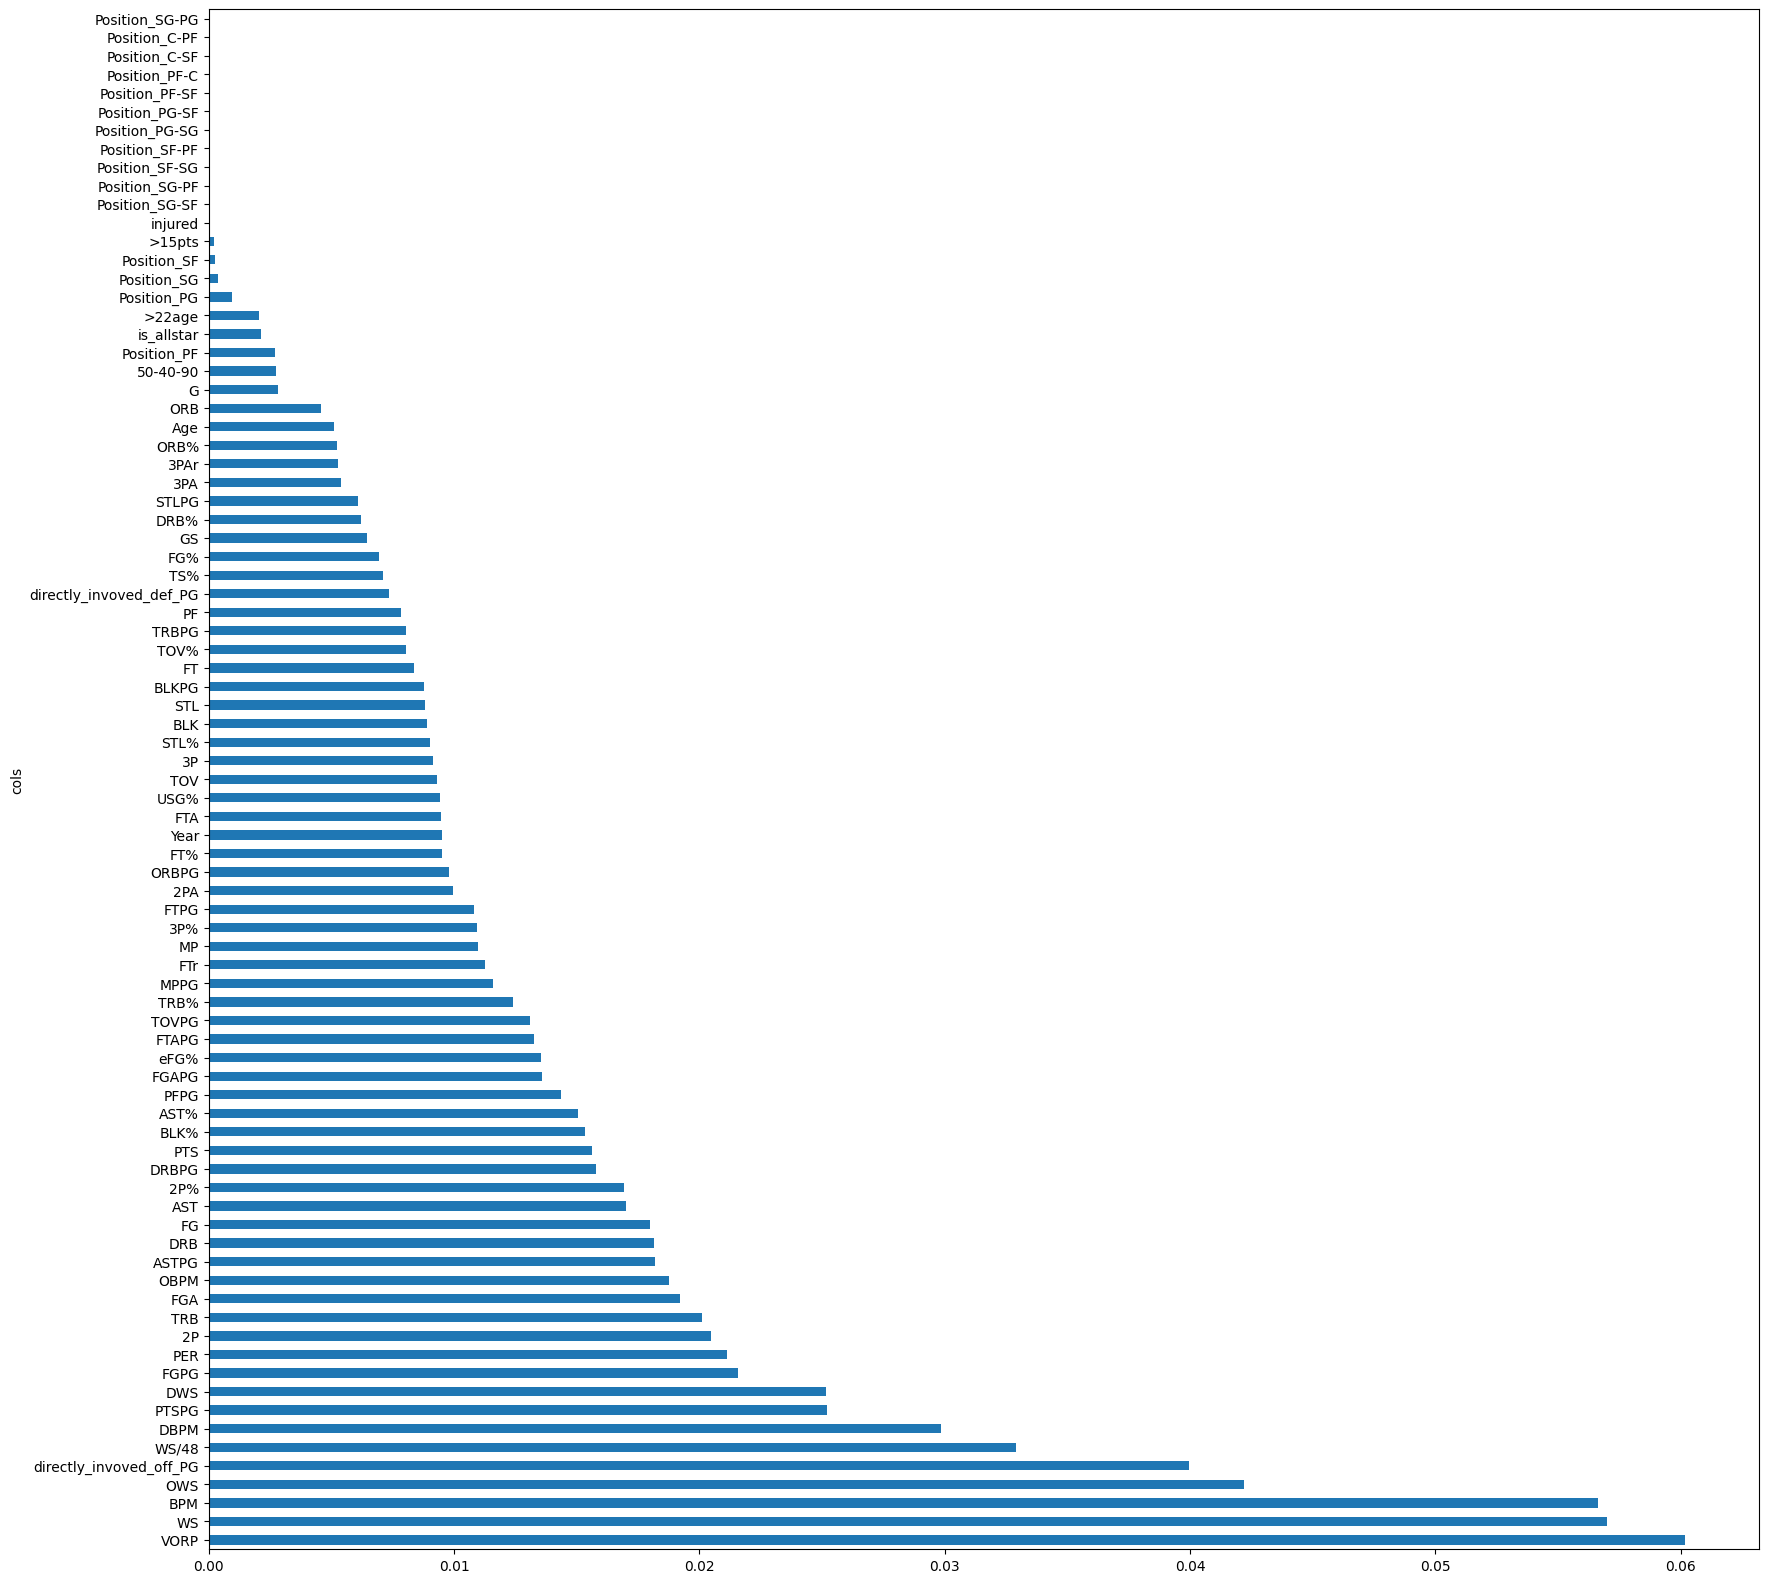

In [34]:
plot_fi(rf_feat_importance(pipe.steps[1][1], X_train))

In [35]:
selector2 = SelectKBest(f_classif, k = 20)
scaler = StandardScaler()
random_classif2 = RFC(n_estimators=100)
pipe = make_pipeline(selector2, scaler, random_classif2)
pipe.fit(X_train, y_train)

/home/courier/Documents/NBA_Analysis/myenv/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [49] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/courier/Documents/NBA_Analysis/myenv/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('selectkbest', SelectKBest(k=20)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [36]:
f1_score(y_test, pipe.predict(X_test), average='macro')

0.5468565466157569

Since the position features are not important, we will drop them. 

In [37]:
columns = stats_df.columns

In [38]:
pos_cols = [column for column in columns if 'Pos' in column]

In [39]:
stats_df = stats_df.drop(columns = pos_cols)

Now we consider another model. 

In [40]:
X_2 = stats_df.drop(columns = ['was_mvp'])
y_2 = stats_df['was_mvp']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,y_2,train_size = 0.7, random_state = 23)

In [41]:
#selector3 = SelectKBest(f_classif, k = 20)
scaler3 = StandardScaler()
random_classif3 = RFC(n_estimators=100)
pipe3 = make_pipeline(scaler3, random_classif3)
pipe3.fit(X_2_train, y_2_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

<AxesSubplot: ylabel='cols'>

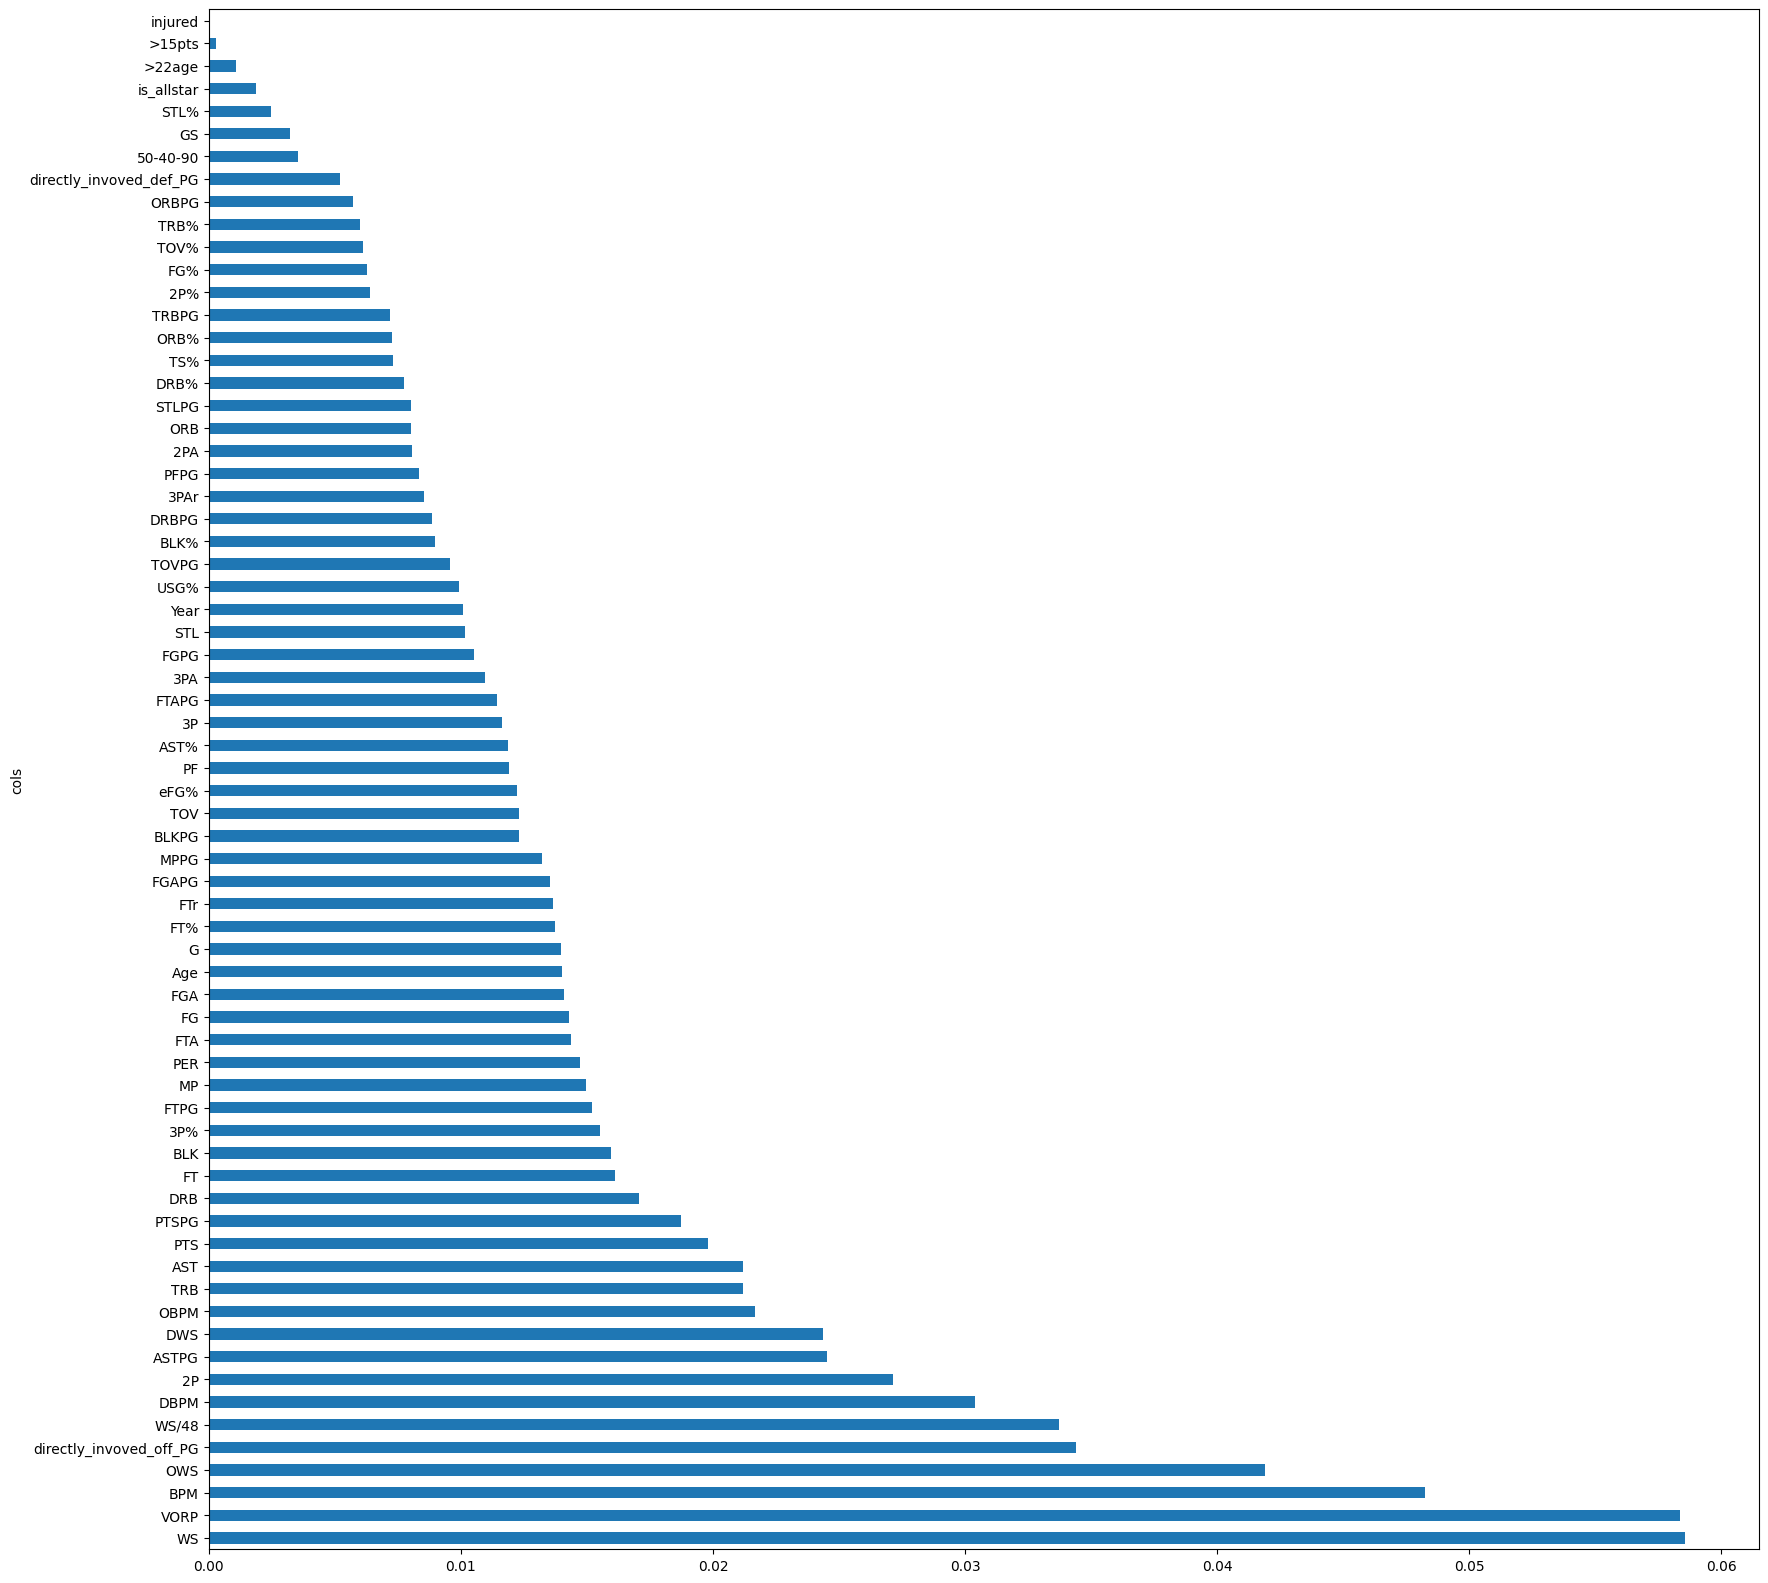

In [42]:
plot_fi(rf_feat_importance(pipe3.steps[1][1], X_2_train))

In [43]:
f1_score(y_2_test, pipe3.predict(X_2_test), average='macro')

0.5468565466157569

In [44]:
stats_df = pd.read_csv('../data/NBA_Stats_MVP.csv')

In [45]:
def replace_null(df):
    """
    This function replaces null values in a dataframe with 0. 
    :param df: The original dataframe.
    :return: A dataframe with null values replaced by 0.
    """
    null = np.where((df.isna),1, 0)
    df['had_null'] = null
    df.fillna(0, inplace = True)
    return df

In [46]:
stats_df_filled = replace_null(stats_df)

In [47]:
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
stats_df_filled = per_game(stats_df_filled, per_game_cols)

In [48]:
X = stats_df_filled.drop(columns = ['was_mvp', 'Pos', 'Name', 'Tm'])
y = stats_df_filled['was_mvp']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 23)

In [49]:
random_classif = RFC(n_estimators=100)
random_classif.fit(X_train, y_train)

RandomForestClassifier()

In [50]:
f1_score(y_train, random_classif.predict(X_train), average='macro')

1.0

In [51]:
f1_score(y_test, random_classif.predict(X_test), average='macro')

0.5468565466157569

<AxesSubplot: ylabel='cols'>

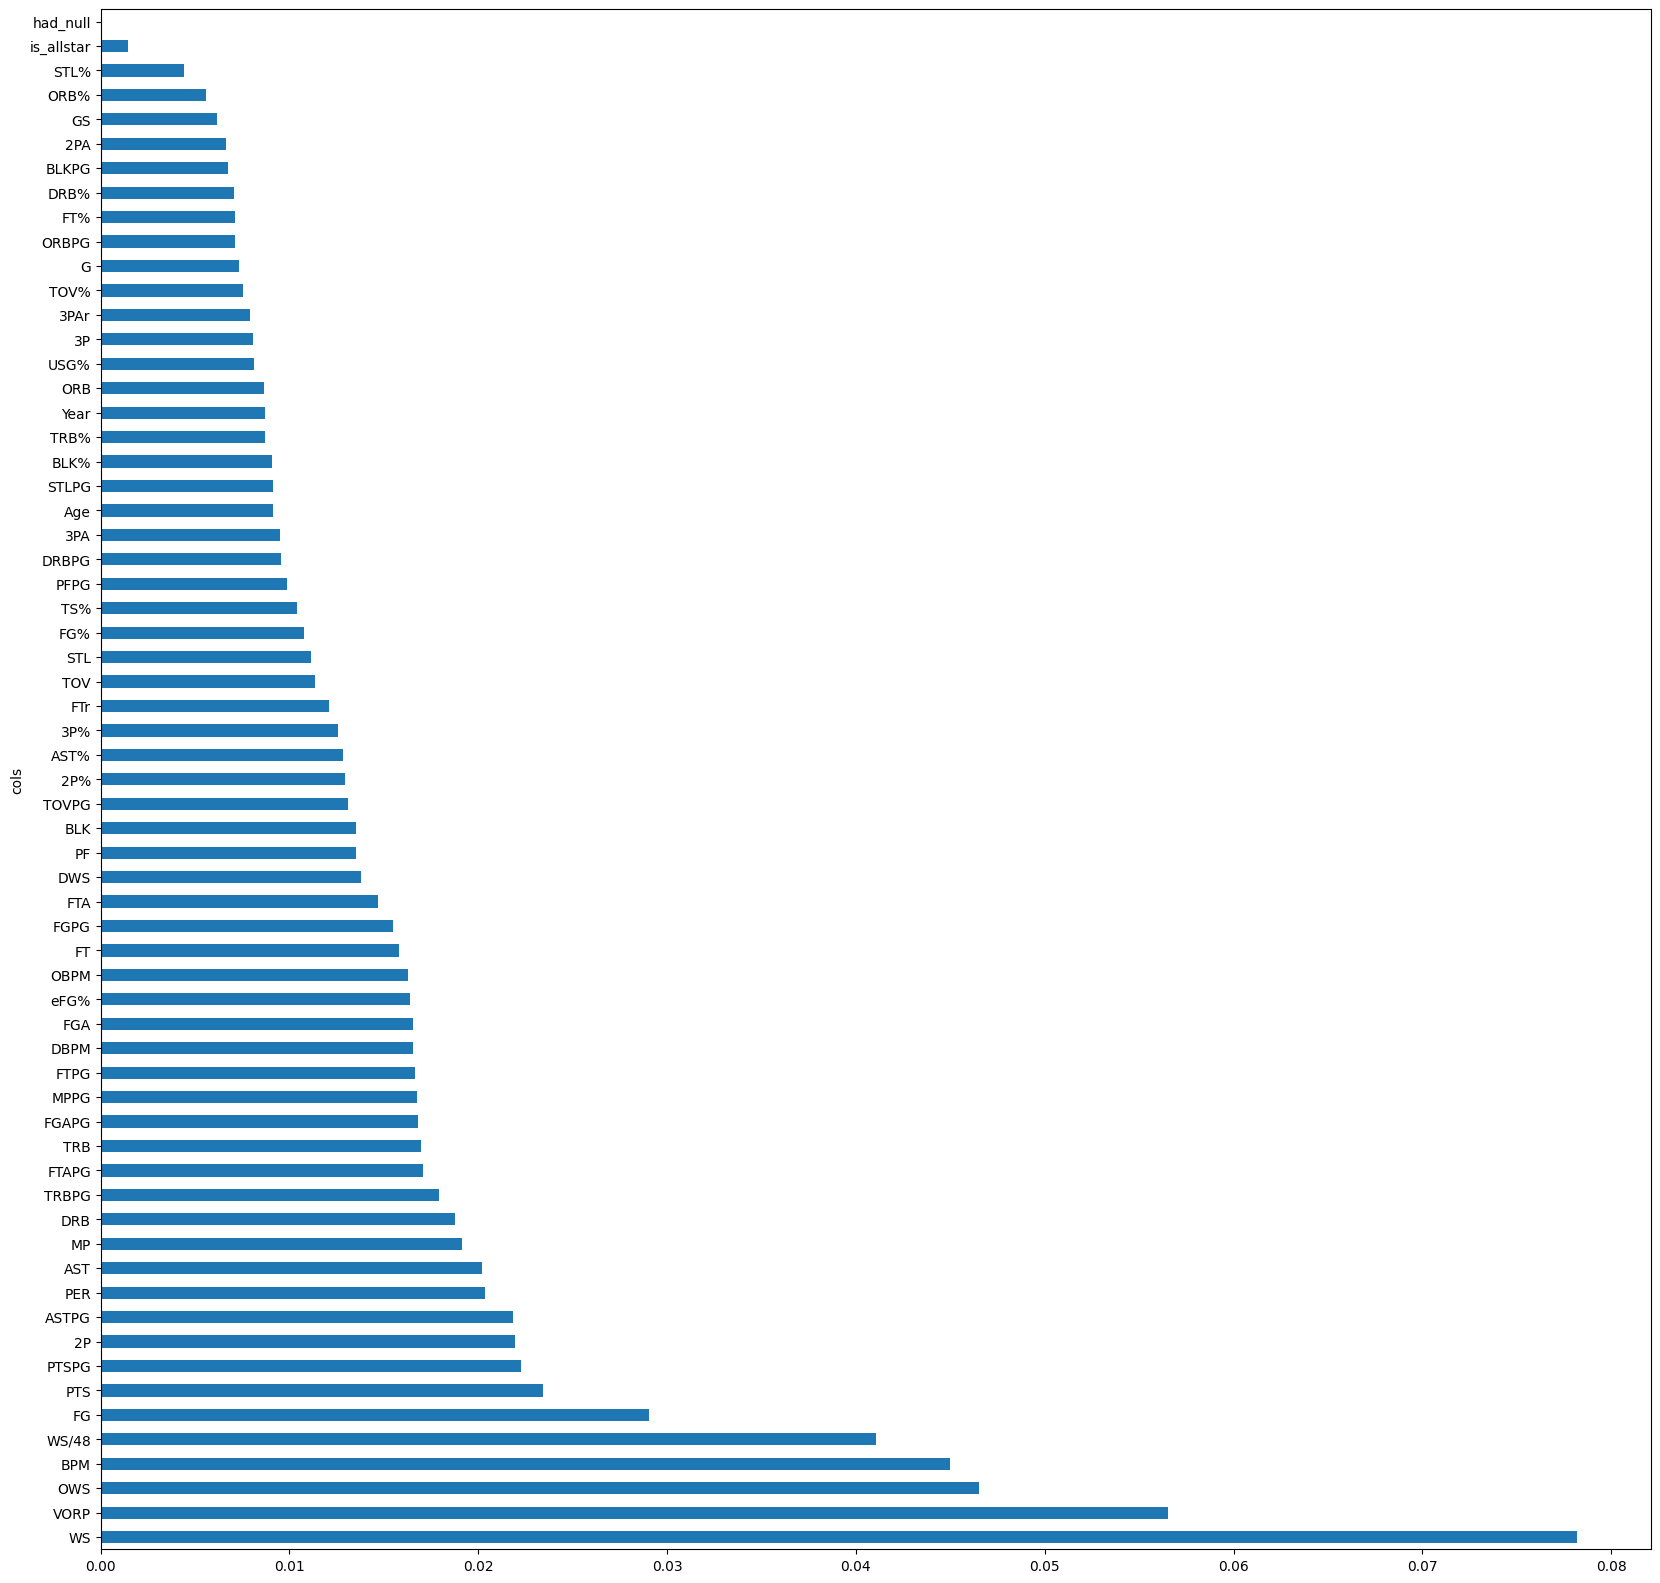

In [52]:
fi = rf_feat_importance(random_classif, X_test)
plot_fi(fi)

In [53]:
keep = fi[fi.imp>0.03].cols

In [54]:
len(keep)

5

In [55]:
important_X = X[keep]

In [56]:
important_X

,WS,VORP,OWS,BPM,WS/48
0,6.5,1.8,3.3,1.0,0.126
1,18.4,9.4,10.6,8.5,0.250
2,3.6,0.5,0.1,-1.1,0.076
3,0.7,-0.2,-0.3,-3.0,0.053
4,8.2,3.4,4.7,3.6,0.164
...,...,...,...,...,...
20792,5.6,1.8,3.4,2.1,0.157
20793,1.0,-0.1,0.5,-2.5,0.094
20794,0.0,-0.1,-0.1,-7.3,-0.005
20795,0.5,-0.4,-0.3,-3.7,0.030


In [57]:
X_train_imp, X_test_imp, y_train, y_test = train_test_split(important_X,y,train_size = 0.7, random_state = 23)

In [58]:
random_classif2 = RFC(n_estimators=100)
random_classif2.fit(X_train_imp, y_train)

RandomForestClassifier()

In [59]:
f1_score(y_train, random_classif2.predict(X_train_imp), average='macro')

1.0

In [60]:
f1_score(y_test, random_classif2.predict(X_test_imp), average='macro')

0.5861938983145499

We will now fit a gradient boosting classifier.

In [61]:
gbc = GBC()

In [62]:
gbc.fit(X_train_imp, y_train)

GradientBoostingClassifier()

In [63]:
f1_score(y_train, gbc.predict(X_train_imp), average='macro')

0.8748280250395541

In [64]:
f1_score(y_test, gbc.predict(X_test_imp), average='macro')

0.5760398265617472

Here we achieve our best score so far with a test f1_score of 62%.

Next we consider a KNN.

In [65]:
neighbors = KNeighborsClassifier(n_neighbors=5)

In [66]:
neighbors.fit(X_train_imp, y_train)

KNeighborsClassifier()

In [67]:
f1_score(y_train, neighbors.predict(X_train_imp), average='macro')

0.742916524530859

In [68]:
f1_score(y_test, neighbors.predict(X_test_imp), average='macro')

0.5446518483924166

Next, we consider a stacking classifier that uses a random forest, gradient boosting classifier, and a knn with k = 5. 

In [69]:
estimators = [('rf',RFC(n_estimators = 100)),('gbc', GBC()), ("neighbors",KNeighborsClassifier(n_neighbors=5))]

In [70]:
stack = StackingClassifier(estimators=estimators, final_estimator=RFC())

In [71]:
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('gbc', GradientBoostingClassifier()),
                               ('neighbors', KNeighborsClassifier())],
                   final_estimator=RandomForestClassifier())

In [72]:
f1_score(y_test, stack.predict(X_test_imp), average='macro')

0.6192372541148133

In [73]:
confusion_matrix(y_test, stack.predict(X_test_imp))

array([[6218,    3],
       [  16,    3]])

In [74]:
f1_score(y_train, stack.predict(X_train_imp), average='macro')

0.7649104575599377

We will now fit an Ada Boost Classifier.

In [75]:
abc = ABC()

In [76]:
abc.fit(X_train_imp,y_train)

AdaBoostClassifier()

In [77]:
f1_score(y_test, abc.predict(X_test_imp), average='macro')

0.666024405908799

In [78]:
f1_score(y_train, abc.predict(X_train_imp), average='macro')

0.9897787155460842

In [79]:
confusion_matrix(y_train, abc.predict(X_train_imp))

array([[14532,     0],
       [    1,    24]])

In [80]:
confusion_matrix(y_test, abc.predict(X_test_imp))

array([[6220,    1],
       [  15,    4]])

In [81]:
accuracy_score(y_train, abc.predict(X_train_imp))

0.9999313045270317

In [103]:
joblib.dump(abc, "adaboost.joblib")

['adaboost.joblib']

In [104]:
abc.classes_

array([0, 1])

Now, we attempt to put this the Ada Booster in our stacked model. 

In [83]:
estimators = [('rf',RFC(n_estimators = 100)),('gbc', GBC()), ("neighbors",KNeighborsClassifier(n_neighbors=5)), 
              ("abc", ABC())]

In [84]:
stack = StackingClassifier(estimators=estimators, final_estimator=RFC())

In [85]:
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('gbc', GradientBoostingClassifier()),
                               ('neighbors', KNeighborsClassifier()),
                               ('abc', AdaBoostClassifier())],
                   final_estimator=RandomForestClassifier())

In [86]:
f1_score(y_test, stack.predict(X_test_imp), average='macro')

0.5901866635531751

Fitting again without the knn.

In [87]:
estimators = [('rf',RFC(n_estimators = 100)),('gbc', GBC()), 
              ("abc", ABC())]

In [88]:
stack = StackingClassifier(estimators=estimators, final_estimator=RFC())

In [89]:
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('gbc', GradientBoostingClassifier()),
                               ('abc', AdaBoostClassifier())],
                   final_estimator=RandomForestClassifier())

In [90]:
f1_score(y_test, stack.predict(X_test_imp), average='macro')

0.5901866635531751

Fitting again without the GBC.

In [91]:
estimators = [('rf',RFC(n_estimators = 100)), ("neighbors",KNeighborsClassifier(n_neighbors=5)), 
              ("abc", ABC())]

In [92]:
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('gbc', GradientBoostingClassifier()),
                               ('abc', AdaBoostClassifier())],
                   final_estimator=RandomForestClassifier())

In [93]:
stack = StackingClassifier(estimators=estimators, final_estimator=RFC())

In [94]:
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('neighbors', KNeighborsClassifier()),
                               ('abc', AdaBoostClassifier())],
                   final_estimator=RandomForestClassifier())

In [95]:
f1_score(y_test, stack.predict(X_test_imp), average='macro')

0.4991572357332049

Fitting again without knn or gbc.

In [96]:
estimators = [('rf',RFC(n_estimators = 100)), 
              ("abc", ABC())]

In [97]:
stack = StackingClassifier(estimators=estimators, final_estimator=RFC())

In [98]:
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('abc', AdaBoostClassifier())],
                   final_estimator=RandomForestClassifier())

In [99]:
f1_score(y_test, stack.predict(X_test_imp), average='macro')

0.5901866635531751

In [100]:
estimators = [('gbc', GBC()), ("neighbors",KNeighborsClassifier(n_neighbors=5)), 
              ("abc", ABC())]

Fitting again without Random Forest.

In [101]:
stack = StackingClassifier(estimators=estimators, final_estimator=ABC())
stack.fit(X_train_imp, y_train)

StackingClassifier(estimators=[('gbc', GradientBoostingClassifier()),
                               ('neighbors', KNeighborsClassifier()),
                               ('abc', AdaBoostClassifier())],
                   final_estimator=AdaBoostClassifier())

In [102]:
f1_score(y_test, stack.predict(X_test_imp), average='macro')

0.5390766760337214